In [34]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy.fftpack import idct

Variable initialization

In [35]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion

C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [36]:
for i in range(M):
    a = np.zeros(M)
    a[i] = 1
    temp = np.reshape(idct(a),-1)
    norm = np.linalg.norm(temp)
    DCT[:, i] = temp/norm


Generating the 1-D standard basis

In [37]:
for i in range(M):
    a = np.zeros(M)
    a[i]=1
    C[:, i] = a


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

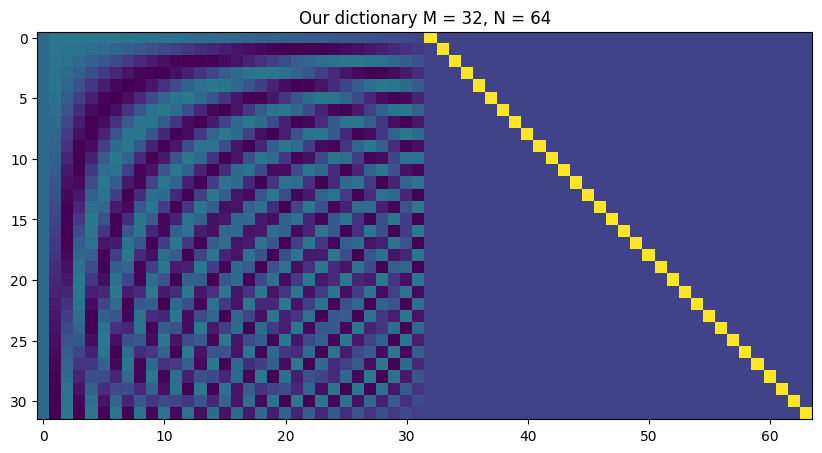

In [38]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $D$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to s that is sparse w.r.t. D. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [39]:
L = 4
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $D$ (make sure the nonzero coefficients are sufficiently large)

In [40]:
x0 = np.zeros(N)
positions = np.random.choice(N, L, replace=False)
x0[positions] = np.random.rand(L)
x0

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.78496275, 0.        , 0.31200053, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.71630781,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2565975 , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Choose spike location

In [41]:
spikeLocation = np.random.choice(positions)
print(spikeLocation)

lambda_spike = np.random.uniform(1,3) + (2*np.abs(max(x0))/x0[spikeLocation]) # para que al menos sea el doble de la señal mas intensa
x0[spikeLocation] = lambda_spike * x0[spikeLocation]

19
3.3505659217510684


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.78496275, 0.        , 0.31200053, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.35056592,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.2565975 , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Synthetize the corresponding signal in the signal domain and add noise


In [42]:
# s0 = Dx
s0 = np.dot(D,x0) # noise free
print(s0.shape)

# add noise
sigma = 10/255
sigma_noise = sigma * (np.random.normal(size=s0.shape))

# s = s0 + eta
s = s0 + sigma_noise
print(s.shape)

(32,)
(32,)


Plot the sparse signal

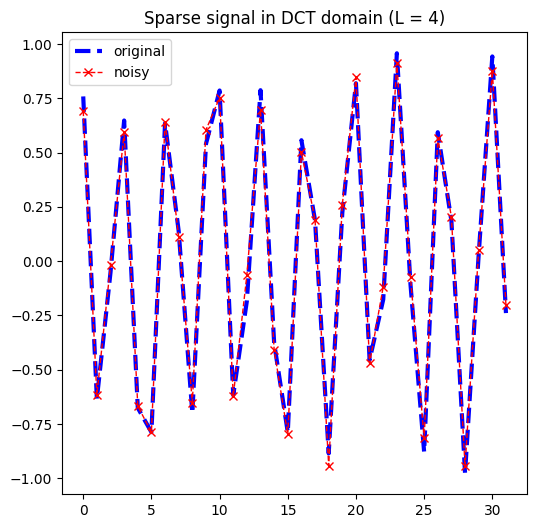

In [43]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Orthogonal Matching Pursuit
---------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [44]:
x_OMP = np.zeros(N)

# residual
r =  s - np.dot(D,x_OMP)

# support set
omega = []

MINIMUM_NORM_RES = 0.1

OMP loop starts.

Stopping criteria: continue until the sparsity of the representation reaches L

In [45]:
while np.linalg.norm(r) > MINIMUM_NORM_RES and np.count_nonzero(x_OMP) < L:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:,j]
        argmax = np.dot(r.T, dj)**2 / np.linalg.norm(dj) # dot product between 2 vectors = escalar
        e[j] = np.linalg.norm(r)**2 - argmax

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    if jStar not in omega: # because omega is a set
        omega.append(jStar) # solution to not obtain a singular matrix

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    D_omega = D[:,omega]
    l_term = np.linalg.inv(np.dot(D_omega.T, D_omega))
    r_term = np.dot(D_omega.T, s)
    x_omega = np.dot(l_term,r_term) 

    x_OMP[omega] = x_omega

    # update the residual
    r = s - np.dot(D,x_OMP)


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [46]:
s_hat_OMP = np.dot(D,x_OMP)
s_hat_OMP

array([ 0.74235829, -0.60588474, -0.04628829,  0.62465795, -0.66094518,
       -0.7739601 ,  0.60035022,  0.12366118, -0.67721623,  0.53094689,
        0.77690856, -0.57825355, -0.16453056,  0.76198621, -0.37594477,
       -0.78184624,  0.51876167,  0.16957004, -0.85533089,  0.22891937,
        0.81063857, -0.42288956, -0.16137921,  0.92452521, -0.11393472,
       -0.86345033,  0.56754483,  0.17152472, -0.9460822 ,  0.0331654 ,
        0.91872704, -0.22223828])

Show the result

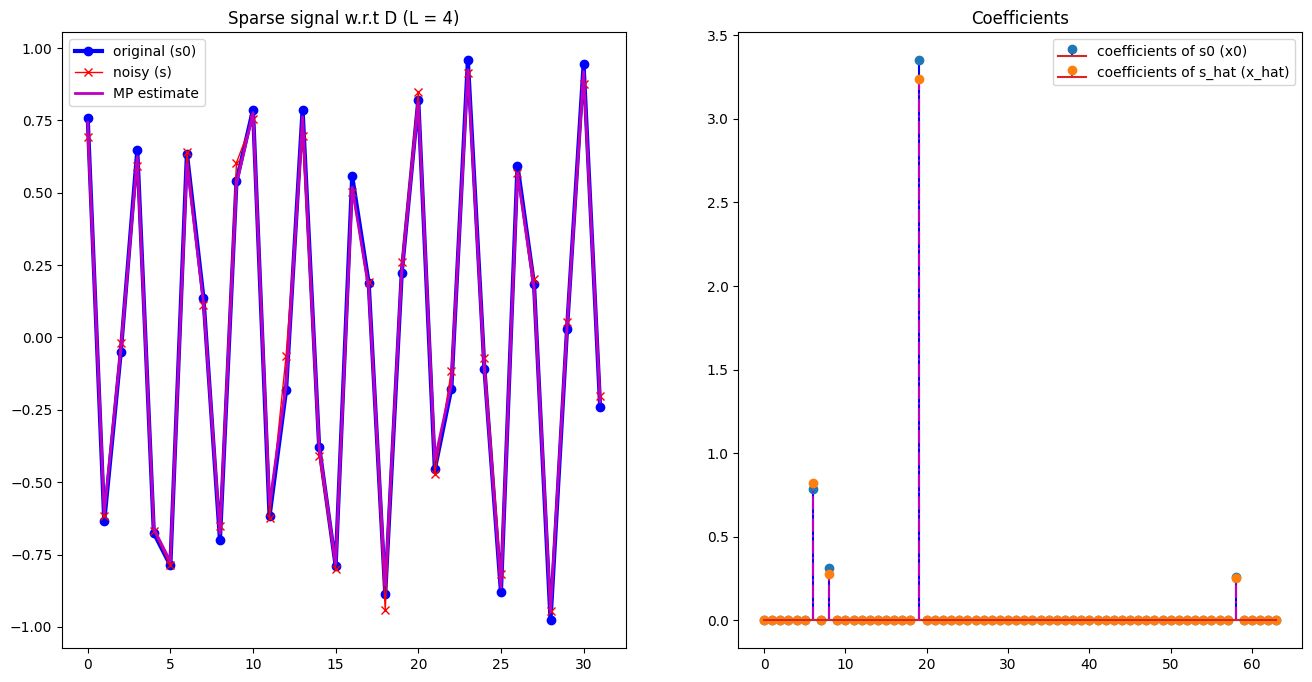

In [47]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_OMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_OMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

Least Squares Orthogonal Matching Pursuit
-----------------------------------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [48]:
x_LSOMP = np.zeros(N)

# residual
r = s - np.dot(D,x_LSOMP)

# support set
omega = []

MINIMUM_NORM_RES = 0.1

LSOMP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L

In [49]:
while np.count_nonzero(x_LSOMP) < L and np.linalg.norm(r, 2) > MINIMUM_NORM_RES:
    # SWEEP STEP: find the best column by solving the LS problem
    if len(omega) == 0:
        # at the first iteration perform the usual sweep step
        e = np.zeros(N)
        for j in range(N):
            dj = D[:,j]
            argmax = np.dot(r.T, dj)**2 / np.linalg.norm(dj) # dot product between 2 vectors = escalar
            e[j] = np.linalg.norm(r)**2 - argmax

        # find the column of D that matches at best r
        jStar = np.argmin(e)
        omega.append(jStar)

        D_omega = D[:,omega]
        l_term = np.linalg.inv(np.dot(D_omega.T, D_omega))
        r_term = np.dot(D_omega.T, s)
        x_omega = np.dot(l_term,r_term) 

        x_LSOMP[jStar] = x_omega
    else:
        # perform the sweep step by solving the LS problem
        e = np.ones(N) * np.inf
        zwu_dict = {}
        for j in range(N):
            if j not in omega: # because omega is a set
                Dw = D[:,omega]
                dj = D[:,j]
                Dw_dj = np.hstack((Dw, dj.reshape((-1,1))))
                l_term = np.dot(Dw_dj.T, Dw_dj)
                r_term = np.dot(Dw_dj.T, s)
                zwu = np.dot(np.linalg.inv(l_term),r_term)
                zwu_dict[j] = zwu
                e[j] = np.linalg.norm(s - np.dot(Dw_dj,zwu))**2
                # print(j)
            
        jStar = np.argmin(e)
        zwu = zwu_dict[jStar]
        
        # UPDATE the support set with the jStar coefficient
        if jStar not in omega:# because omega is a set
            omega.append(jStar)
            
        # update the coefficients
        x_LSOMP[omega] = zwu
        
    # update the residual
    r = s - np.dot(D, x_LSOMP)

C:\Users\Angela\AppData\Local\Temp\ipykernel_6592\3242177056.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_LSOMP[jStar] = x_omega


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [50]:
s_hat_LSOMP = np.dot(D,x_LSOMP)

Show the result

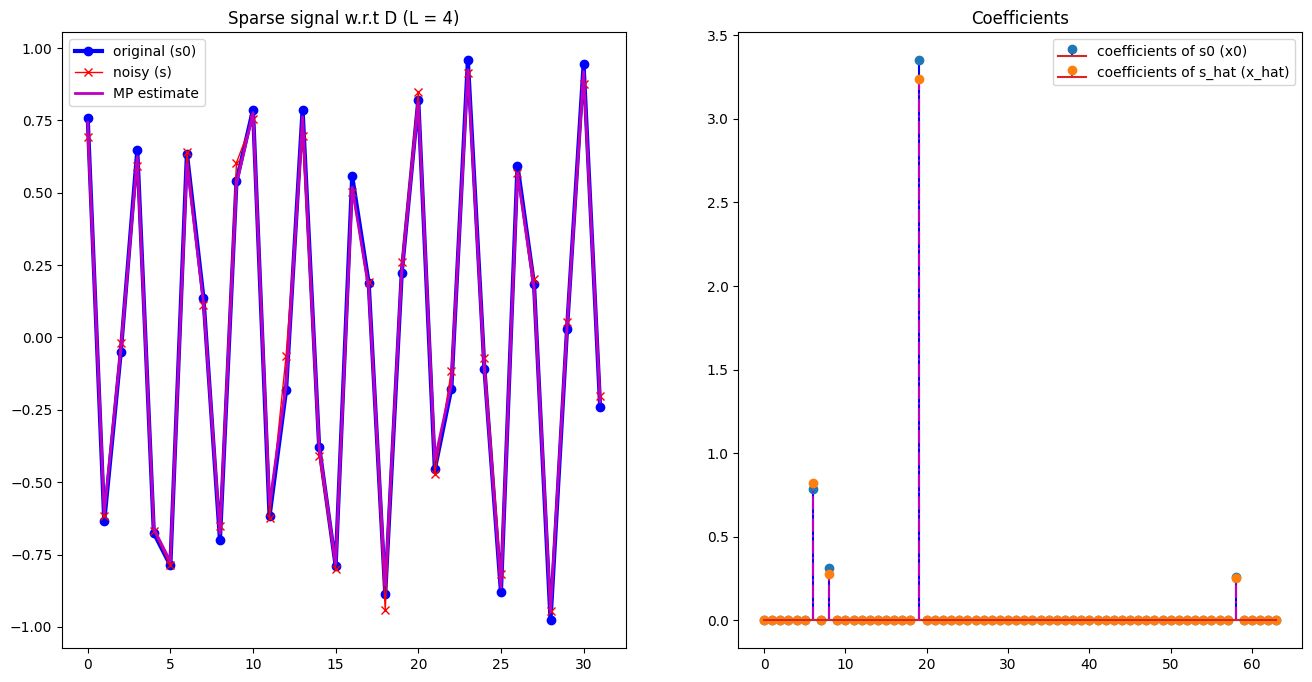

In [51]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_LSOMP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal w.r.t D (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_LSOMP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])